# Udacity Machine Learning Capstone Project
## Dogs vs. Cats Redux - Kaggle Compeition

## Load modules

In [1]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

# Load the modules
import pickle
import math

from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from resizeimage import resizeimage


print('All modules imported.')

All modules imported.


## Preprocess and Load Data

In [ ]:
# Define a function to resize the image to desired dimension
def resize_image(img, size):
    """
    Resize PIL image
    
    Resizes image to be square with sidelength size. Pads with black if needed.
    """
    # Resize
    n_x, n_y = img.size
    if n_y > n_x:
        n_y_new = size
        n_x_new = int(size * n_x / n_y + 0.5)
    else:
        n_x_new = size
        n_y_new = int(size * n_y / n_x + 0.5)

    img_res = img.resize((n_x_new, n_y_new), resample=Image.ANTIALIAS)

    # Pad the borders to create a square image
    img_pad = Image.new('RGB', (size, size), (128, 128, 128))
    #img_pad = Image.new('L', (size, size))
    ulc = ((size - n_x_new) // 2, (size - n_y_new) // 2)
    img_pad.paste(img_res, ulc)

    return img_pad

In [ ]:
SIZE = 32

# Unzip, load images and return feature and labels
def uncompress_features_labels(file):
    """
    Uncompress features and labels from a zip file
    :param file: The zip file to extract the data from
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Get features and labels from all files
        for filename in filenames_pbar:
            # Check if the file is a directory
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    img = resize_image(image, SIZE)
                    feature = np.array(img, dtype=np.float32)
                # Get the the letter from the filename.  This is the letter of the image.
                label = os.path.split(filename)[1][0:3]
                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Get the features and labels from the zip files
X_train, y_train_string = uncompress_features_labels('train_sub.zip')
# Wait until you see that all features and labels have been uncompressed.
print('All features and labels uncompressed.')

In [ ]:
# # Implement Min-Max scaling for grayscale image data
# def normalize_grayscale(image_data):
#     """
#     Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
#     :param image_data: The image data to be normalized
#     :return: Normalized image data
#     """
#     # TODO: Implement Min-Max scaling for grayscale image data
#     a = 0.1
#     b = 0.9
#     grayscale_min = 0
#     grayscale_max = 255
#     return a + ((image_data - grayscale_min)*(b-a))/(grayscale_max - grayscale_min)

# X_train = normalize_grayscale(X_train)

In [ ]:
# Turn labels into numbers and apply One-Hot Encoding
labels = []
for item in y_train_string:
    if item == 'cat':
        labels.append(1)
    else:
        labels.append(0)
        
y_train = np.array(labels)

In [ ]:
# Get randomized datasets for training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=0)

print('Training features and labels randomized and split.')

In [ ]:
print('Training size is: {}'.format(len(X_train)))
print('Validation size is: {}'.format(len(X_val))) 

In [ ]:
X_val.shape

## Visualize Image

In [ ]:
print('Updated Image Shape: {}'.format(X_train[0].shape))
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image)
print(y_train[index])

## Save Data

In [ ]:
# Save the data for easy access
pickle_file = 'DogCat_{0}px.pickle'.format(SIZE)
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': X_train,
                    'train_labels': y_train,
                    'valid_dataset': X_val,
                    'valid_labels': y_val,
                },
                pfile)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

## Load Data

In [2]:
SIZE = 32

# Reload the data
pickle_file = 'DogCat_{0}px.pickle'.format(SIZE)
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  X_train = pickle_data['train_dataset']
  y_train = pickle_data['train_labels']
  X_val = pickle_data['valid_dataset']
  y_val = pickle_data['valid_labels']
  del pickle_data  # Free up memory
    
print('Data and modules loaded.')

Data and modules loaded.


In [5]:
print(X_train.shape)
print(X_val.shape)

(4800, 32, 32, 3)
(1200, 32, 32, 3)


## Implement LeNet-5 as Baseline in TensorFlow

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. C is 3 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Relu

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Relu

**Layer 5: Fully Connected (Logits).** This should have 3 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [6]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0.0
    sigma = 1.0
    weights = {
        'wc1': tf.Variable(tf.truncated_normal((5, 5, 3, 6), mean = mu, stddev = sigma)),
        'wc2': tf.Variable(tf.truncated_normal((5, 5, 6, 16), mean = mu, stddev = sigma)),
        'wf1': tf.Variable(tf.truncated_normal((400, 120), mean = mu, stddev = sigma)),
        'wf2': tf.Variable(tf.truncated_normal((120, 84), mean = mu, stddev = sigma)),
        'wf3': tf.Variable(tf.truncated_normal((84, 2), mean = mu, stddev = sigma))
    }
    
    biases = {
        'bc1': tf.Variable(tf.zeros(6)),
        'bc2': tf.Variable(tf.zeros(16)),
        'bf1': tf.Variable(tf.zeros(120)),
        'bf2': tf.Variable(tf.zeros(84)),
        'bf3': tf.Variable(tf.zeros(2))
    }
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv_layer1 = tf.nn.conv2d(x, weights['wc1'], strides = [1, 1, 1, 1], padding = 'VALID')
    conv_layer1 = tf.nn.bias_add(conv_layer1, biases['bc1'])
    # TODO: Activation.
    conv_layer1 = tf.nn.relu(conv_layer1)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv_layer1 = tf.nn.max_pool(conv_layer1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv_layer2 = tf.nn.conv2d(conv_layer1, weights['wc2'], strides = [1, 1, 1, 1], padding = 'VALID')
    conv_layer2 = tf.nn.bias_add(conv_layer2, biases['bc2'])
    
    # TODO: Activation.
    conv_layer2 = tf.nn.relu(conv_layer2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv_layer2 = tf.nn.max_pool(conv_layer2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv_layer2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(fc0, weights['wf1']), biases['bf1'])
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wf2']), biases['bf2'])

    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 2.
    fc3 = tf.add(tf.matmul(fc2, weights['wf3']), biases['bf3'])
    logits = fc3
    return logits

## Features and Labels

In [9]:
x = tf.placeholder(tf.float32, (None, SIZE, SIZE, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 2)

## Training Pipeline

In [10]:
EPOCHS = 10
BATCH_SIZE = 128
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_val, y_val)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './DogsCats_lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.557

EPOCH 2 ...
Validation Accuracy = 0.553

EPOCH 3 ...
Validation Accuracy = 0.534

EPOCH 4 ...
Validation Accuracy = 0.535

EPOCH 5 ...
Validation Accuracy = 0.534

EPOCH 6 ...
Validation Accuracy = 0.544

EPOCH 7 ...
Validation Accuracy = 0.539

EPOCH 8 ...
Validation Accuracy = 0.545

EPOCH 9 ...
Validation Accuracy = 0.558

EPOCH 10 ...
Validation Accuracy = 0.557

Model saved



Epoch  1/10:   0%|          | 0/38 [00:00<?, ?batches/s]

Training...




Epoch 10/10: 100%|██████████| 38/38 [00:06<00:00,  5.99batches/s]


Model saved


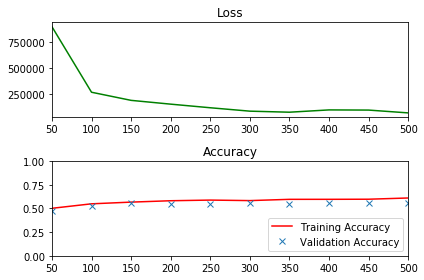

In [16]:
# # Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    batch_count = int(math.ceil(num_examples/BATCH_SIZE))
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        X_val, y_val = shuffle(X_val, y_val)
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(i+1, EPOCHS), unit='batches')
        
         # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*BATCH_SIZE
            batch_features = X_train[batch_start:batch_start + BATCH_SIZE]
            batch_labels = y_train[batch_start:batch_start + BATCH_SIZE]

            # Run optimizer and get loss
            _, l = sess.run(
                [training_operation, loss_operation],
                feed_dict={x: batch_features, y: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = sess.run(accuracy_operation, feed_dict={x: X_train, y: y_train})
                validation_accuracy = sess.run(accuracy_operation, feed_dict={x: X_val, y: y_val})

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
    saver.save(sess, './DogsCats_lenet2')
    print("Model saved")
    
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()